In [ ]:
## PCA/TSNE analysis
## https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/005_Chemical_space_analysis_and_visualization.ipynb

## Peter M.U. Ung @ gRED
## Analysis the chemical diversity and overlaps of multiple libraries' glutarimide analogs. Specifically the lactam
## and phthalimide core analogs. Do R-Group decomposition to extract the exit vectors R1-R4 on the core phenyl ring.
## Phthalimide core has internal symmetry so might need to rearrange R1-->R4 or R2-->R3 vectors, since R3/R4 are 
## biologically more relevant. Since many cpds has [H] substituent as exit vector, need to remove them to better 
## analyze the true chemical space. Use t-SNE to better spread out the chemical space for visualization. 

# python 3.9

In [1]:
import re
import pandas as pd      # 1.4.3
from rdkit import Chem   # 2022.09
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Cluster import Butina
from rdkit.Chem import PandasTools as rdpd
from rdkit.Chem import rdRGroupDecomposition

In [2]:
import numpy as np           # 1.23.1
import seaborn as sns        # 0.11.2
import matplotlib.pyplot as plt  # 3.5.1
from sklearn.manifold import TSNE  # 1.1.1
from sklearn.decomposition import PCA

In [3]:
## Take in pre-calculated Degrader_CRBN data
df_1 = rdpd.LoadSDF(filename='CRBN_lib_example.Murcko_clust.tsne.sdf.gz', removeHs=False).reset_index(drop=True)
len(df_1)

15922

In [4]:
## Defined SMARTS of CRBN binders (glutarimide w/ lactam or phthalimide core)
crbn_seles = ['[#6]-1(=[#8])-[#7;H1]-[#6](=[#8])-[#6;H2]-[#6;H2]-[#6;H1]1-[#7]-2-[#6](=[#8])-[#6;H0]3[#6;X3][#6;X3][#6;X3][#6;X3][#6;H0]3-[#6]2(=[#8])',
              '[#6]-1(=[#8])-[#7;H1]-[#6](=[#8])-[#6;H2]-[#6;H2]-[#6;H1]1-[#7]-2-[#6](=[#8])-[#6;H0]3[#6;X3][#6;X3][#6;X3][#6;X3][#6;H0]3-[#6;H2]2']

crbn_cores = ['[#6]-1(=[#8])-[#7;H1]-[#6](=[#8])-[#6;H2]-[#6;H2]-[#6;H1]1-[#7]-2-[#6](=[#8])-[#6;H0]3[#6](-[*:1])[#6](-[*:2])[#6](-[*:3])[#6](-[*:4])[#6]3-[#6]2(=[#8])',
              '[#6]-1(=[#8])-[#7;H1]-[#6](=[#8])-[#6;H2]-[#6;H2]-[#6;H1]1-[#7]-2-[#6](=[#8])-[#6;H0]3[#6](-[*:1])[#6](-[*:2])[#6](-[*:3])[#6](-[*:4])[#6]3-[#6;H2]2']

In [5]:
## Filter out with only the strict glutarimide series
sele = [ df_1[df_1.ROMol >= Chem.MolFromSmarts(smarts)] for smarts in crbn_seles ]
df_x = pd.concat(sele).reset_index(drop=True)
len(df_x)

10115

In [6]:
## Recalculate the grouping of the Murcko structures
df_x['Mol_murcko'] = df_x['Murcko_smiles'].map(Chem.MolFromSmiles)
df_x['Mol_hetero_murcko'] = df_x['hetero_Murcko_smiles'].map(Chem.MolFromSmiles)

In [7]:
## generic Murcko identity grouping
group = df_x[['Murcko_smiles']].groupby(['Murcko_smiles']).sum()
group['murcko_num'] = df_x[['Murcko_smiles']].groupby(['Murcko_smiles']).size()
group.sort_values(by=['murcko_num','Murcko_smiles'], ascending=[False,False], inplace=True)
group.reset_index(inplace=True)
group

Murcko_smiles  murcko_num
0                       CC1CCC(C2C(C)C3CCCCC3C2C)C(C)C1         615
1                          CC1CCC(C2CC3CCCCC3C2C)C(C)C1         354
2           CC1CCC(C2CC3C(CC(C)C4CCCCC4)CCCC3C2C)C(C)C1         233
3      CC(CCC1CCCC2C(C)C(C3CCC(C)CC3C)C(C)C12)CC1CCCCC1         219
4         CC1CCC(C2CC3C(CC(C)CCC4CCCCC4)CCCC3C2C)C(C)C1         132
...                                                 ...         ...
2600  CC(CC1CCC(C(C)C2CCCCC2)CC1)CC1CCC2C(C)C(C3CCC(...           1
2601          CC(CC1CC1)CC1CCC2CC(C3CCC(C)CC3C)C(C)C2C1           1
2602       CC(CC1CC1)CC1CCC2C(C)C(C3CCC(C)CC3C)C(C)C2C1           1
2603  CC(CC1CC(C2CCCCC2)C1)CC1CCC2C(C1)CC(C1CCC(C)CC...           1
2604  CC(CC(C)CC1CCCC2C(C)C(C3CCC(C)CC3C)CC12)CC1CCCCC1           1

[2605 rows x 2 columns]

In [8]:
clusters = []
for clust_id, item in group.iterrows():
    tmp = df_x[df_x['Murcko_smiles'].isin([item['Murcko_smiles']])].index
    clusters.append([ [row, clust_id, item['murcko_num'], i] for i, row in enumerate(tmp) ])

## Reorder the flattened list of lists, so that 1st element corresponds to df_all index number
## *_identical_id: the Murcko group/cluster ID
## *_num: number of members within this Murcko group/cluster
## *_group_num: within this Murcko group/cluster, the rank number id (rank has no meaning)
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_x['murcko_identical_id'] = list(zip(*clust_combine))[1]
df_x['murcko_num'] = list(zip(*clust_combine))[2]
df_x['murcko_group_num'] = list(zip(*clust_combine))[3]

In [9]:
## hetero Murcko identity grouping
h_group = df_x[['hetero_Murcko_smiles']].groupby(['hetero_Murcko_smiles']).sum()
h_group['hetero_murcko_num'] = df_x[['hetero_Murcko_smiles']].groupby(['hetero_Murcko_smiles']).size()
h_group.sort_values(by=['hetero_murcko_num','hetero_Murcko_smiles'], ascending=[False,False], inplace=True)
h_group.reset_index(inplace=True)
h_group

hetero_Murcko_smiles  hetero_murcko_num
0                   O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1                615
1                       O=C1CCC(N2Cc3ccccc3C2=O)C(=O)N1                354
2       O=C1CCC(N2Cc3c(NC(=O)c4ccccc4)cccc3C2=O)C(=O)N1                185
3     O=C1CCC(N2C(=O)c3cccc(OCC(=O)Nc4ccccc4)c3C2=O)...                181
4             O=C1CCC(N2Cc3cc(-n4ccnn4)ccc3C2=O)C(=O)N1                 88
...                                                 ...                ...
4897  C=C1COCCN(C(=O)c2cn(-c3ccc4c(c3)C(=O)N(C3CCC(=...                  1
4898  C=C1CCN(C(=O)c2cn(-c3ccc4c(c3)CN(C3CCC(=O)NC3=...                  1
4899  C=C1CCN(C(=O)c2cn(-c3ccc4c(c3)C(=O)N(C3CCC(=O)...                  1
4900  C=C1CC(NC(=O)CCCCCCCNc2cccc3c2C(=O)N(C2CCC(=O)...                  1
4901  C=C(C(=O)N(Cc1cccc2[nH]ccc12)c1ccc2c(c1)C(=O)N...                  1

[4902 rows x 2 columns]

In [10]:
clusters = []
for clust_id, item in h_group.iterrows():
    tmp = df_x[df_x['hetero_Murcko_smiles'].isin([item['hetero_Murcko_smiles']])].index
    clusters.append([ [row, clust_id, item['hetero_murcko_num'], i] for i, row in enumerate(tmp) ])
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_x['hetero_identical_id'] = list(zip(*clust_combine))[1]
df_x['hetero_murcko_num'] = list(zip(*clust_combine))[2]
df_x['hetero_murcko_group_num'] = list(zip(*clust_combine))[3]

In [11]:
## Do the R-group decomposition
scaffolds = [Chem.MolFromSmarts(smarts) for smarts in crbn_cores]
groups,unmatch = rdRGroupDecomposition.RGroupDecompose(scaffolds, df_x['ROMol'], asSmiles=False, asRows=False)

[20:25:09] No core matches


In [12]:
unmatch

[1870]

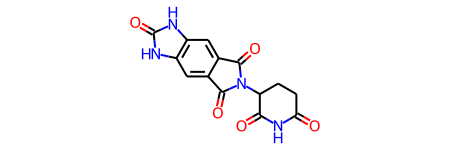

In [13]:
df_x.ROMol[1870]

In [14]:
## Remove unmatched from source df for index matching
df_clean = df_x.drop(index=unmatch).reset_index(drop=True)
len(df_clean)

10114

In [15]:
## Convert R-group decomposition Dict to dframe
df_rg = rdpd.RGroupDecompositionToFrame(groups, df_clean['ROMol'], include_core=True, redraw_sidechains=True)

[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:26:45] WARNING: not removing hydrogen atom with

Mol  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                Core  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R1  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R2  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R3  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R4  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...
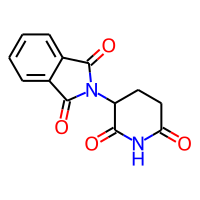
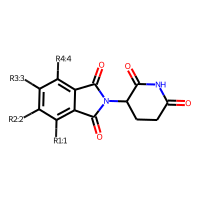
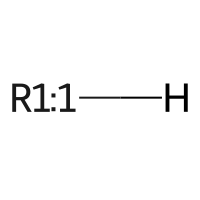
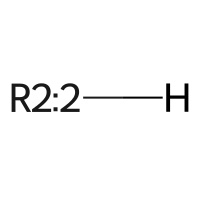
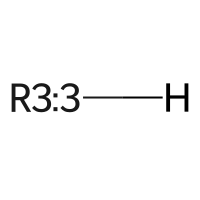
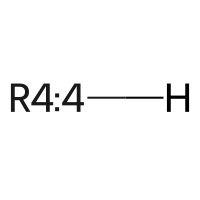
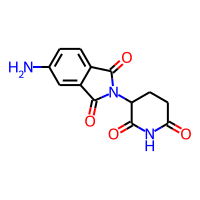
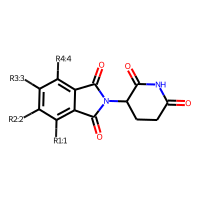
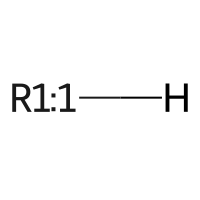
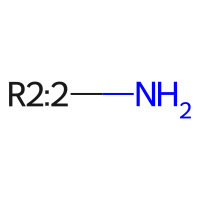
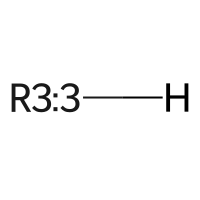
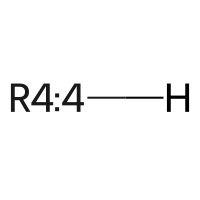
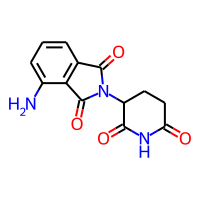
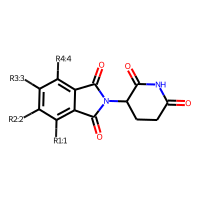
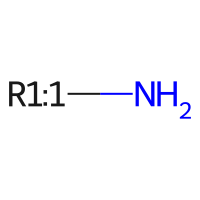
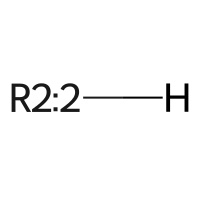
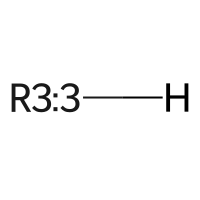
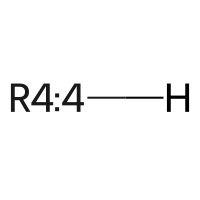
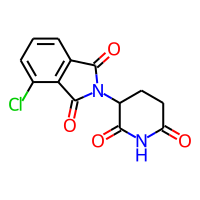
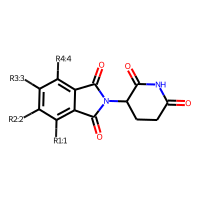
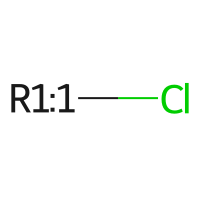
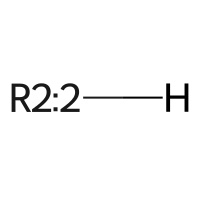
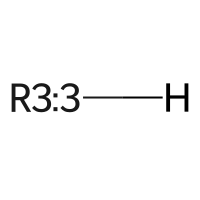
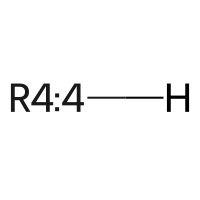
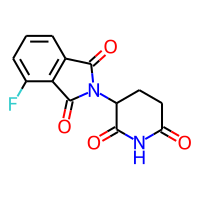
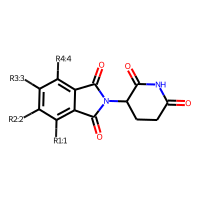
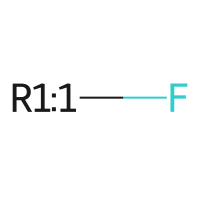
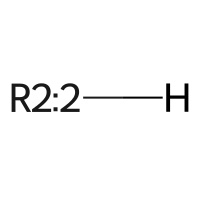
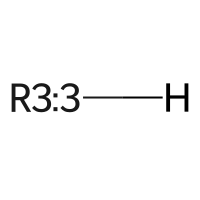
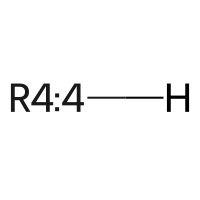

In [16]:
(df_rg[:5])

In [17]:
## Specific case: deal with symmetry of phthalimide, since R1/R4 and R2/R3 can be mirrored
## From the lactam core (most used moiety), R3/R4 positions are more populated, so mirroring to 
## R3/R4 if R2/R1 are populated with heavier moiety
def DeSymmPhthalimide(df, mol, core, r1, r2, r3, r4):
    phthalimide = 'O=C1CCC(N2C(=O)c3c(c([*:4])c([*:3])c([*:2])c3[*:1])C2=O)C(=O)N1'
    new_dict = { mol:[], core:[], r1:[], r2:[], r3:[], r4:[] }
    df['Core_smi'] = df[core].map(Chem.MolToSmiles)
    df[r1+'mw'] = df[r1].map(Descriptors.MolWt)
    df[r2+'mw'] = df[r2].map(Descriptors.MolWt)
    df[r3+'mw'] = df[r3].map(Descriptors.MolWt)
    df[r4+'mw'] = df[r4].map(Descriptors.MolWt)
        
    for idx, row in df.iterrows():
        new_dict[mol].append(row[mol])
        new_dict[core].append(row[core])
        if   (row['Core_smi'] == phthalimide) and (row[r1+'mw'] > row[r4+'mw']):
#            print('case1: {0}'.format(idx))
            new_dict[r1].append(Chem.MolFromSmiles(re.sub('4','1',Chem.MolToSmiles(row[r4]))))
            new_dict[r2].append(Chem.MolFromSmiles(re.sub('3','2',Chem.MolToSmiles(row[r3]))))
            new_dict[r3].append(Chem.MolFromSmiles(re.sub('2','3',Chem.MolToSmiles(row[r2]))))
            new_dict[r4].append(Chem.MolFromSmiles(re.sub('1','4',Chem.MolToSmiles(row[r1]))))
        elif (row['Core_smi'] == phthalimide) and (row[r1+'mw'] == row[r4+'mw']) and (row[r2+'mw'] > row[r3+'mw']):
#            print('case2: {0}'.format(idx))
            new_dict[r1].append(Chem.MolFromSmiles(re.sub('4','1',Chem.MolToSmiles(row[r4]))))
            new_dict[r2].append(Chem.MolFromSmiles(re.sub('3','2',Chem.MolToSmiles(row[r3]))))
            new_dict[r3].append(Chem.MolFromSmiles(re.sub('2','3',Chem.MolToSmiles(row[r2]))))
            new_dict[r4].append(Chem.MolFromSmiles(re.sub('1','4',Chem.MolToSmiles(row[r1]))))
        else:
            new_dict[r1].append(row[r1])
            new_dict[r2].append(row[r2])
            new_dict[r3].append(row[r3])
            new_dict[r4].append(row[r4])

    return pd.DataFrame.from_dict(new_dict)

In [18]:
df_desym = DeSymmPhthalimide( df_rg.copy(), 'Mol', 'Core', 'R1','R2','R3','R4' )

[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:28:40] WARNING: not removing hydrogen atom with

Mol  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                Core  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R1  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R2  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R3  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                                  R4  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...
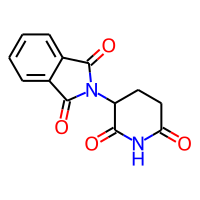
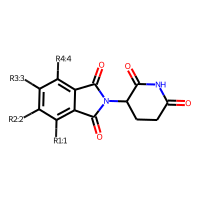
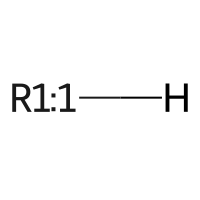
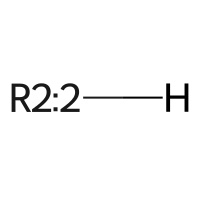
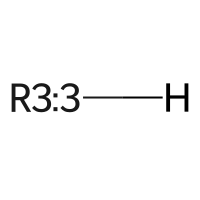
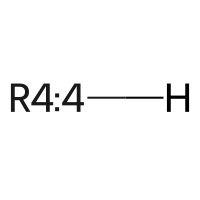
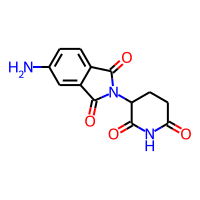
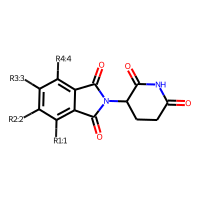
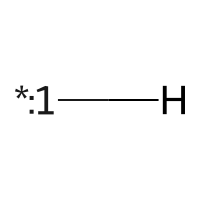
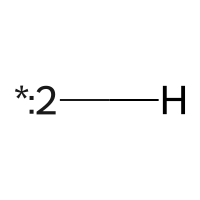
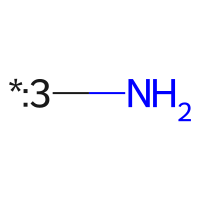
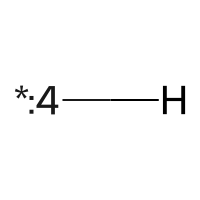
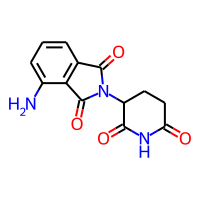
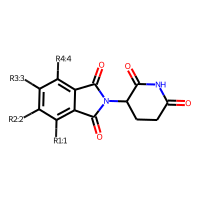
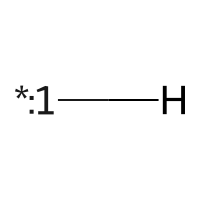
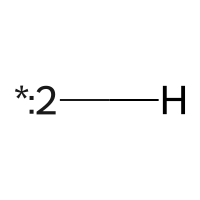
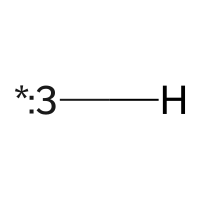
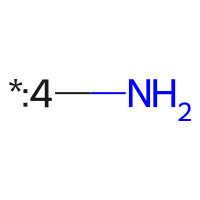
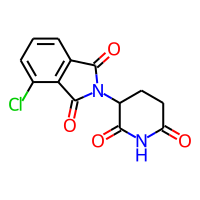
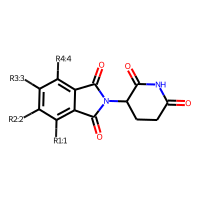
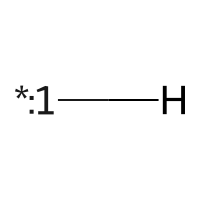
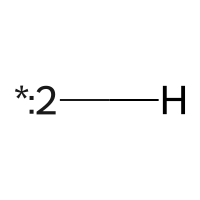
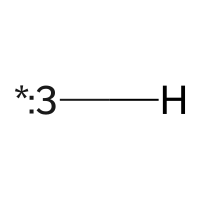
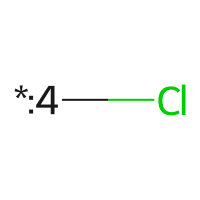
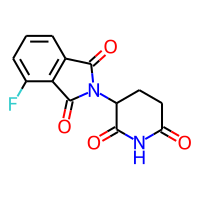
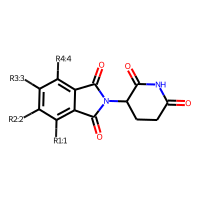
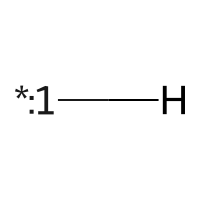
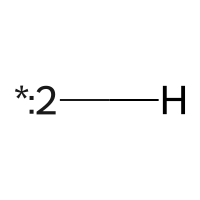
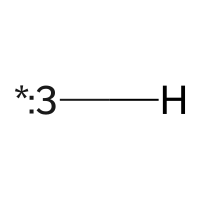
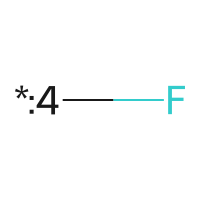

In [19]:
#num = 1
#df_rg.loc[[num]]
#df_desym.loc[[num]]
df_desym[:5]

In [20]:
## Specifically for R3, somehow this has None data in place of H
def testNone(m):
    return Chem.MolFromSmiles('[H][*:3]') if m is None else m

df_desym['R3'] = df_desym['R3'].map(testNone)

df_clean['Core smiles'] = df_desym['Core'].map(Chem.MolToSmiles)
df_clean['R1 smiles'] = df_desym['R1'].map(Chem.MolToSmiles)
df_clean['R2 smiles'] = df_desym['R2'].map(Chem.MolToSmiles)
df_clean['R3 smiles'] = df_desym['R3'].map(Chem.MolToSmiles)
df_clean['R4 smiles'] = df_desym['R4'].map(Chem.MolToSmiles)

[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[20:30:22] WARNING: not removing hydrogen atom with

In [21]:
df_clean['Core'] = df_desym['Core']
df_clean['R1'] = df_desym['R1']
df_clean['R2'] = df_desym['R2']
df_clean['R3'] = df_desym['R3']
df_clean['R4'] = df_desym['R4']
df_clean['R1 mw'] = df_clean['R1'].map(Descriptors.MolWt)
df_clean['R2 mw'] = df_clean['R2'].map(Descriptors.MolWt)
df_clean['R3 mw'] = df_clean['R3'].map(Descriptors.MolWt)
df_clean['R4 mw'] = df_clean['R4'].map(Descriptors.MolWt)
df_clean['R1 cLogP'] = df_clean['R1'].map(Descriptors.MolLogP)
df_clean['R2 cLogP'] = df_clean['R2'].map(Descriptors.MolLogP)
df_clean['R3 cLogP'] = df_clean['R3'].map(Descriptors.MolLogP)
df_clean['R4 cLogP'] = df_clean['R4'].map(Descriptors.MolLogP)
df_clean['R1 fCsp3'] = df_clean['R1'].map(Descriptors.FractionCSP3)
df_clean['R2 fCsp3'] = df_clean['R2'].map(Descriptors.FractionCSP3)
df_clean['R3 fCsp3'] = df_clean['R3'].map(Descriptors.FractionCSP3)
df_clean['R4 fCsp3'] = df_clean['R4'].map(Descriptors.FractionCSP3)

In [22]:
## R-group identity grouping: R1
group1 = df_clean[['R1 smiles']].groupby(['R1 smiles']).sum()
group1['R1_num'] = df_clean[['R1 smiles']].groupby(['R1 smiles']).size()
group1.sort_values(by=['R1_num','R1 smiles'], ascending=[False,False], inplace=True)
group1.reset_index(inplace=True)
(group1[:5])

R1 smiles  R1_num
0                     [H][*:1]   10080
1                       F[*:1]       6
2                       N[*:1]       2
3              c1ccc([*:1])cc1       1
4  O=S(=O)(N[*:1])c1sccc1C1CC1       1

In [23]:
clusters = []
for clust_id, item in group1.iterrows():
    tmp = df_clean[df_clean['R1 smiles'].isin([item['R1 smiles']])].index
    clusters.append([ [row, clust_id, item['R1_num'], i] for i, row in enumerate(tmp) ])

## Reorder the flattened list of lists, so that 1st element corresponds to df_all index number
## *_identical_id: the Murcko group/cluster ID
## *_num: number of members within this Murcko group/cluster
## *_group_num: within this Murcko group/cluster, the rank number id (rank has no meaning)
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R1_identical_id'] = list(zip(*clust_combine))[1]
df_clean['R1_num'] = list(zip(*clust_combine))[2]
df_clean['R1_group_num'] = list(zip(*clust_combine))[3]

In [24]:
## R-group identity grouping: R2
group2 = df_clean[['R2 smiles']].groupby(['R2 smiles']).sum()
group2['R2_num'] = df_clean[['R2 smiles']].groupby(['R2 smiles']).size()
group2.sort_values(by=['R2_num','R2 smiles'], ascending=[False,False], inplace=True)
group2.reset_index(inplace=True)

clusters = []
for clust_id, item in group2.iterrows():
    tmp = df_clean[df_clean['R2 smiles'].isin([item['R2 smiles']])].index
    clusters.append([ [row, clust_id, item['R2_num'], i] for i, row in enumerate(tmp) ])

## Reorder the flattened list of lists, so that 1st element corresponds to df_all index number
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R2_identical_id'] = list(zip(*clust_combine))[1]
df_clean['R2_num'] = list(zip(*clust_combine))[2]
df_clean['R2_group_num'] = list(zip(*clust_combine))[3]
group2[:5]

R2 smiles  R2_num
0               [H][*:2]    8309
1                 F[*:2]     328
2                 N[*:2]       2
3                CO[*:2]       2
4  c1sc([*:2])nc1C1OCCO1       1

In [25]:
len(group2)

1477

In [26]:
## R-group identity grouping: R3
group3 = df_clean[['R3 smiles']].groupby(['R3 smiles']).sum()
group3['R3_num'] = df_clean[['R3 smiles']].groupby(['R3 smiles']).size()
group3.sort_values(by=['R3_num','R3 smiles'], ascending=[False,False], inplace=True)
group3.reset_index(inplace=True)

clusters = []
for clust_id, item in group3.iterrows():
    tmp = df_clean[df_clean['R3 smiles'].isin([item['R3 smiles']])].index
    clusters.append([ [row, clust_id, item['R3_num'], i] for i, row in enumerate(tmp) ])

## Reorder the flattened list of lists, so that 1st element corresponds to df_all index number
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R3_identical_id'] = list(zip(*clust_combine))[1]
df_clean['R3_num'] = list(zip(*clust_combine))[2]
df_clean['R3_group_num'] = list(zip(*clust_combine))[3]
group3[:5]

R3 smiles  R3_num
0                    [H][*:3]    6418
1                      F[*:3]     166
2            C1CNCCN([*:3])C1       5
3  C1CC(CN2CCN([*:3])CC2)CCN1       5
4                      O[*:3]       4

In [27]:
len(group3)

3258

In [28]:
## R-group identity grouping: R4
group4 = df_clean[['R4 smiles']].groupby(['R4 smiles']).sum()
group4['R4_num'] = df_clean[['R4 smiles']].groupby(['R4 smiles']).size()
group4.sort_values(by=['R4_num','R4 smiles'], ascending=[False,False], inplace=True)
group4.reset_index(inplace=True)

clusters = []
for clust_id, item in group4.iterrows():
    tmp = df_clean[df_clean['R4 smiles'].isin([item['R4 smiles']])].index
    clusters.append([ [row, clust_id, item['R4_num'], i] for i, row in enumerate(tmp) ])

## Reorder the flattened list of lists, so that 1st element corresponds to df_all index number
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R4_identical_id'] = list(zip(*clust_combine))[1]
df_clean['R4_num'] = list(zip(*clust_combine))[2]
df_clean['R4_group_num'] = list(zip(*clust_combine))[3]
group4[:5]

R4 smiles  R4_num
0                    [H][*:4]    5052
1                      F[*:4]       6
2           O=C(O)CCCCCN[*:4]       5
3                      O[*:4]       4
4  c1cc(CN2CCOCC2)ccc1CO[*:4]       3

In [29]:
len(group4)

4747

In [30]:
class FP:
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return '{0} bit FP'.format(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=2048, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    mol : rdkit.Chem.rdchem.Mol
    radius : float      Fingerprint radius, default 2
    nBits : int         Length of hashed fingerprint (without descriptors), default 2048
    useFeatures : bool  To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool       If True, returns for each bit number of appearances of each substructure (counts). Default False (fingerprint is binary)
    dtype : np.dtype    Numpy data type. Defaults to np.float32 for scikit-learn
    Returns
    ML.FP               Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)
    if counts is True:
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures)
    DataStructs.ConvertToNumpyArray(fp, arr)    
    return FP(arr, range(nBits))

In [31]:
df_clean['Fullfp'] = df_clean['ROMol'].map(get_cfps)
df_clean['R1fp'] = df_clean['R1'].map(get_cfps)
df_clean['R2fp'] = df_clean['R2'].map(get_cfps)
df_clean['R3fp'] = df_clean['R3'].map(get_cfps)
df_clean['R4fp'] = df_clean['R4'].map(get_cfps)

In [32]:
## PCA analysis: R1
R1_FP_data = df_clean['R1fp'].map(lambda m: m.fp).tolist() # extract FP as np.array
pca = PCA(n_components=3, random_state=0)
pca_full = pca.fit_transform(R1_FP_data)
df_clean['PCA_R1_1'] = pca_full.T[0]
df_clean['PCA_R1_2'] = pca_full.T[1]
df_clean['PCA_R1_3'] = pca_full.T[2]

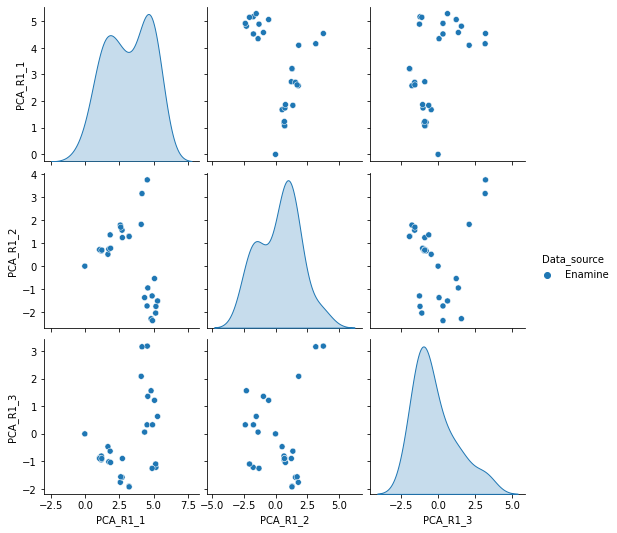

In [33]:
data = df_clean[df_clean['R1_num'] > 0].groupby('R1_identical_id').nth(0).reset_index()
sns.pairplot(data, hue='Data_source', vars=['PCA_R1_1','PCA_R1_2','PCA_R1_3'])

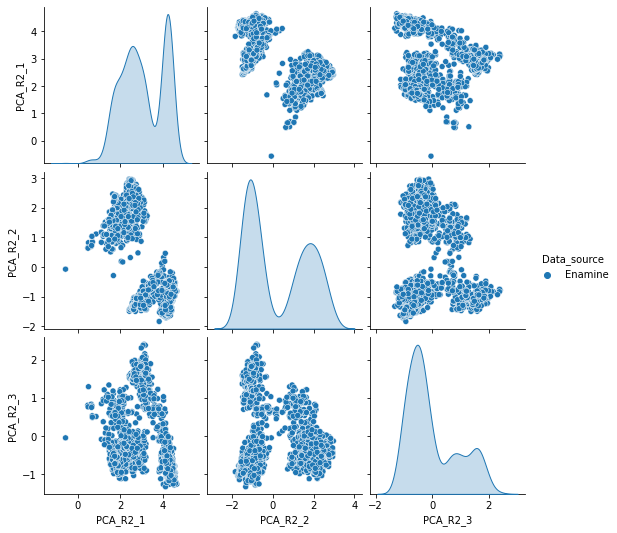

In [34]:
## PCA analysis: R2
R2_FP_data = df_clean['R2fp'].map(lambda m: m.fp).tolist()
pca = PCA(n_components=3, random_state=0)
pca_R2 = pca.fit_transform(R2_FP_data)
df_clean['PCA_R2_1'] = pca_R2.T[0]
df_clean['PCA_R2_2'] = pca_R2.T[1]
df_clean['PCA_R2_3'] = pca_R2.T[2]
data = df_clean[df_clean['R2_num'] > 0].groupby('R2_identical_id').nth(0).reset_index()
sns.pairplot(data, hue='Data_source', vars=['PCA_R2_1','PCA_R2_2','PCA_R2_3'])

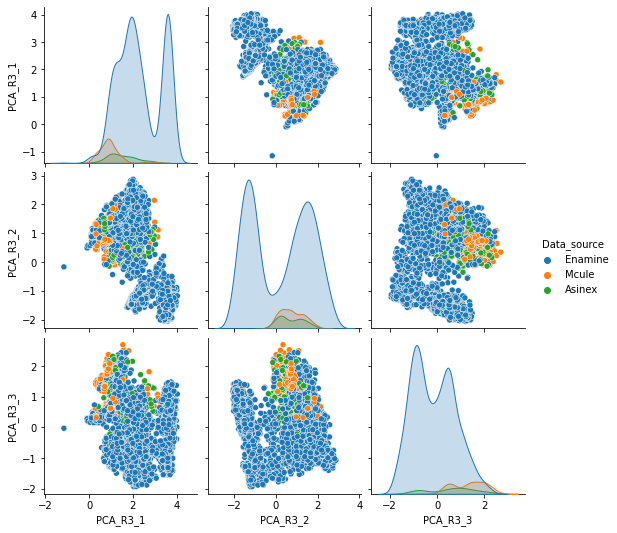

In [35]:
## PCA analysis: R3
R3_FP_data = df_clean['R3fp'].map(lambda m: m.fp).tolist()
pca = PCA(n_components=3, random_state=0)
pca_R3 = pca.fit_transform(R3_FP_data)
df_clean['PCA_R3_1'] = pca_R3.T[0]
df_clean['PCA_R3_2'] = pca_R3.T[1]
df_clean['PCA_R3_3'] = pca_R3.T[2]
data = df_clean[df_clean['R3_num'] > 0].groupby('R3_identical_id').nth(0).reset_index()
sns.pairplot(data, hue='Data_source', vars=['PCA_R3_1','PCA_R3_2','PCA_R3_3'])

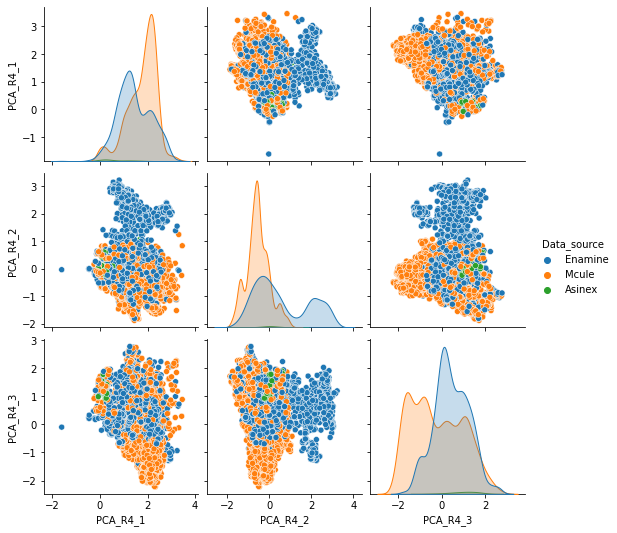

In [36]:
## PCA analysis: R4
R4_FP_data = df_clean['R4fp'].map(lambda m: m.fp).tolist()
pca = PCA(n_components=3, random_state=0)
pca_R4 = pca.fit_transform(R4_FP_data)
df_clean['PCA_R4_1'] = pca_R4.T[0]
df_clean['PCA_R4_2'] = pca_R4.T[1]
df_clean['PCA_R4_3'] = pca_R4.T[2]
data = df_clean[df_clean['R4_num'] > 0].groupby('R4_identical_id').nth(0).reset_index()
sns.pairplot(data, hue='Data_source', vars=['PCA_R4_1','PCA_R4_2','PCA_R4_3'])

In [37]:
def CalcFPTanimoto( Fp, cutoff=0.4 ):
    ## Generate the FP distance matrix:
    ## This scheme is more efficient as only half of the matrix is calculated
    ## as it is symmetric, O(0.5*N^2-N). Another version of math that uses
    ## Pandas mapping has no shortcut, O(N^2), much slower even as serialized
    dists = []
    for i in list(range(1, len(Fp))):  # starting @ 1 to avoid self-calculation
        sims = DataStructs.BulkTanimotoSimilarity(Fp[i], Fp[:i])
        dists.extend([1-x for x in sims])

    ## Cluster the data into list of lists of positional index (df or array), 
    ## each list with members within the cutoff:
    FP_clusters = Butina.ClusterData(dists, len(Fp), float(cutoff), isDistData=True)
    return FP_clusters

In [38]:
## Whole-molecule clustering by Tanimoto cutoff with ECFP4_2048
df_clean['ecfp4'] = df_clean['ROMol'].map(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))
FP_clusters = CalcFPTanimoto(df_clean['ecfp4'], cutoff=0.4)

clusters = []
for clust_id, clust_members in enumerate(FP_clusters):
    indexes = df_clean[df_clean.index.isin(clust_members)].index.tolist()
    clusters.append( [[row, clust_id, len(clust_members), i] for i, row in enumerate(indexes)] )

## combine the list of indexes and sort it to match df_all index, remerge cluster info into df
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['whole_cluster_id'] = list(zip(*clust_combine))[1]
df_clean['whole_cluster_num'] = list(zip(*clust_combine))[2]
df_clean['whole_cluster_group_num'] = list(zip(*clust_combine))[3]

print("## No. of cluster: "+str(len(clusters))+" for Tc = "+str(0.4)+" ##\n")

## No. of cluster: 866 for Tc = 0.4 ##



In [39]:
## R1 clustering by Tanimoto cutoff with ECFP4_2048
df_clean['R1_ecfp4'] = df_clean['R1'].map(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))
FP_clusters = CalcFPTanimoto(df_clean['R1_ecfp4'], cutoff=0.4)

clusters = []
for clust_id, clust_members in enumerate(FP_clusters):
    indexes = df_clean[df_clean.index.isin(clust_members)].index.tolist()
    clusters.append( [[row, clust_id, len(clust_members), i] for i, row in enumerate(indexes)] )

## combine the list of indexes and sort it to match df_all index, remerge cluster info into df
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R1_cluster_id'] = list(zip(*clust_combine))[1]
df_clean['R1_cluster_num'] = list(zip(*clust_combine))[2]
df_clean['R1_cluster_group_num'] = list(zip(*clust_combine))[3]

print("## No. of cluster: "+str(len(clusters))+" for Tc = "+str(0.4)+" ##\n")

## No. of cluster: 27 for Tc = 0.4 ##



In [40]:
## R2 clustering by Tanimoto cutoff with ECFP4_2048
df_clean['R2_ecfp4'] = df_clean['R2'].map(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))
FP_clusters = CalcFPTanimoto(df_clean['R2_ecfp4'], cutoff=0.4)

clusters = []
for clust_id, clust_members in enumerate(FP_clusters):
    indexes = df_clean[df_clean.index.isin(clust_members)].index.tolist()
    clusters.append( [[row, clust_id, len(clust_members), i] for i, row in enumerate(indexes)] )

## combine the list of indexes and sort it to match df_all index, remerge cluster info into df
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R2_cluster_id'] = list(zip(*clust_combine))[1]
df_clean['R2_cluster_num'] = list(zip(*clust_combine))[2]
df_clean['R2_cluster_group_num'] = list(zip(*clust_combine))[3]

print("## No. of cluster: "+str(len(clusters))+" for Tc = "+str(0.4)+" ##\n")

## No. of cluster: 1109 for Tc = 0.4 ##



In [41]:
## R3 clustering by Tanimoto cutoff with ECFP4_2048
df_clean['R3_ecfp4'] = df_clean['R3'].map(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))
FP_clusters = CalcFPTanimoto(df_clean['R3_ecfp4'], cutoff=0.4)

clusters = []
for clust_id, clust_members in enumerate(FP_clusters):
    indexes = df_clean[df_clean.index.isin(clust_members)].index.tolist()
    clusters.append( [[row, clust_id, len(clust_members), i] for i, row in enumerate(indexes)] )

## combine the list of indexes and sort it to match df_all index, remerge cluster info into df
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R3_cluster_id'] = list(zip(*clust_combine))[1]
df_clean['R3_cluster_num'] = list(zip(*clust_combine))[2]
df_clean['R3_cluster_group_num'] = list(zip(*clust_combine))[3]

print("## No. of cluster: "+str(len(clusters))+" for Tc = "+str(0.4)+" ##\n")

## No. of cluster: 2360 for Tc = 0.4 ##



In [42]:
## R4 clustering by Tanimoto cutoff with ECFP4_2048
df_clean['R4_ecfp4'] = df_clean['R4'].map(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))
FP_clusters = CalcFPTanimoto(df_clean['R4_ecfp4'], cutoff=0.4)

clusters = []
for clust_id, clust_members in enumerate(FP_clusters):
    indexes = df_clean[df_clean.index.isin(clust_members)].index.tolist()
    clusters.append( [[row, clust_id, len(clust_members), i] for i, row in enumerate(indexes)] )

## combine the list of indexes and sort it to match df_all index, remerge cluster info into df
clust_combine = sorted([i for itm in clusters for i in itm], key=lambda x: x[0])
df_clean['R4_cluster_id'] = list(zip(*clust_combine))[1]
df_clean['R4_cluster_num'] = list(zip(*clust_combine))[2]
df_clean['R4_cluster_group_num'] = list(zip(*clust_combine))[3]

print("## No. of cluster: "+str(len(clusters))+" for Tc = "+str(0.4)+" ##\n")

## No. of cluster: 2415 for Tc = 0.4 ##



In [43]:
## PCA Analysis: whole molecule
whole_FP_data = df_clean['Fullfp'].map(lambda m: m.fp).tolist()
pca = PCA(n_components=3, random_state=0)
pca_whole = pca.fit_transform(whole_FP_data)
df_clean['PCA_whole_1'] = pca_whole.T[0]
df_clean['PCA_whole_2'] = pca_whole.T[1]
df_clean['PCA_whole_3'] = pca_whole.T[2]

In [44]:
datax = df_clean[df_clean['whole_cluster_num'].map(int) > 1].groupby('whole_cluster_id').nth(0).reset_index()
len(datax)

417

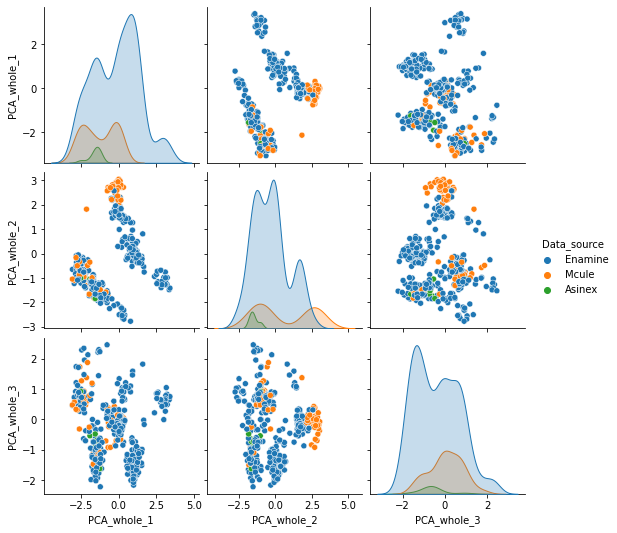

In [45]:
sns.pairplot(datax, hue='Data_source', vars=['PCA_whole_1','PCA_whole_2','PCA_whole_3'])

In [46]:
## TSNE with PCA preprocessing: Settings
pca_model  = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000, n_jobs=-1,
                  learning_rate='auto', init='pca')

In [47]:
## TSNE with PCA preprocessing: generic Murcko 
murcko_FP_data = df_clean['Mol_murcko'].map(get_cfps).map(lambda m: m.fp).tolist()
tsne_pca_murcko = tsne_model.fit_transform(pca_model.fit_transform(murcko_FP_data))
df_clean['TSNE_murcko_1'] = tsne_pca_murcko.T[0]
df_clean['TSNE_murcko_2'] = tsne_pca_murcko.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [48]:
## TSNE with PCA preprocessing: hetero Murcko 
hetero_FP_data = df_clean['Mol_hetero_murcko'].map(get_cfps).map(lambda m: m.fp).tolist()
tsne_pca_hetero = tsne_model.fit_transform(pca_model.fit_transform(hetero_FP_data))
df_clean['TSNE_hetero_1'] = tsne_pca_hetero.T[0]
df_clean['TSNE_hetero_2'] = tsne_pca_hetero.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [49]:
## TSNE with PCA preprocessing: R1 (everything)
tsne_pca_R1 = tsne_model.fit_transform(pca_model.fit_transform(R1_FP_data))
df_clean['TSNE_R1_1'] = tsne_pca_R1.T[0]
df_clean['TSNE_R1_2'] = tsne_pca_R1.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [50]:
## TSNE with PCA preprocessing: R2 (everything)
tsne_pca_R2 = tsne_model.fit_transform(pca_model.fit_transform(R2_FP_data))
df_clean['TSNE_R2_1'] = tsne_pca_R2.T[0]
df_clean['TSNE_R2_2'] = tsne_pca_R2.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [51]:
## TSNE with PCA preprocessing: R3 (everything)
tsne_pca_R3 = tsne_model.fit_transform(pca_model.fit_transform(R3_FP_data))
df_clean['TSNE_R3_1'] = tsne_pca_R3.T[0]
df_clean['TSNE_R3_2'] = tsne_pca_R3.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [52]:
## TSNE with PCA preprocessing: R4 (everything)
tsne_pca_R4 = tsne_model.fit_transform(pca_model.fit_transform(R4_FP_data))
df_clean['TSNE_R4_1'] = tsne_pca_R4.T[0]
df_clean['TSNE_R4_2'] = tsne_pca_R4.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [53]:
## TSNE with PCA preprocessing: whole molecule
tsne_pca_whole = tsne_model.fit_transform(pca_model.fit_transform(whole_FP_data))
df_clean['TSNE_whole_1'] = tsne_pca_whole.T[0]
df_clean['TSNE_whole_2'] = tsne_pca_whole.T[1]

/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [54]:
## Only showing the 1st appearing mol in the 'murcko_identical_id' group/cluster with more than X members
data3 = df_clean[df_clean['R4_num'] > 0].groupby('R4_identical_id').nth(0).reset_index()
len(data3)

4747

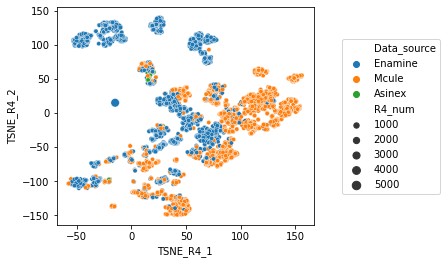

In [55]:
## The issue with analyzing all compounds is that with the [H] substituent, which dominate the plot by 
## pushing everything else away from it, squeezing the plot and other grouping. May need to remove
## entries with only [H] to make the plot more spread out
sns_tsne = sns.scatterplot(data=data3, x='TSNE_R4_1', y='TSNE_R4_2', size='R4_num',hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_tsne.legend(loc='center right', bbox_to_anchor=(1.51,.5))

In [196]:
sns_tsne.figure.savefig('Degrader_CRBN.all_lib.RGroup_x.tSNE.png', dpi=300)

In [57]:
## TSNE with PCA preprocessing: R1 (no [H] substituent)
R1_noH = df_clean[ ~df_clean['R1 smiles'].isin(['[H][*:1]']) ]   ## subset, but keep index unchanged
R1_noH['R1fp_arr'] = R1_noH['R1fp'].map(lambda m: m.fp) ## Extract FP as np.array

tsne_pca_R1 = tsne_model.fit_transform(pca_model.fit_transform(R1_noH['R1fp_arr'].tolist()))
R1_noH['TSNE_R1noH_1'] = tsne_pca_R1.T[0]
R1_noH['TSNE_R1noH_2'] = tsne_pca_R1.T[1]

/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/3477740645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R1_noH['R1fp_arr'] = R1_noH['R1fp'].map(lambda m: m.fp) ## Extract FP as np.array
/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/3477740645.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [58]:

## TSNE with PCA preprocessing: R2 (no [H] substituent)
R2_noH = df_clean[ ~df_clean['R2 smiles'].isin(['[H][*:2]']) ]   ## subset, but keep index
R2_noH['R2fp_arr'] = R2_noH['R2fp'].map(lambda m: m.fp) ## Extract FP as np.array

tsne_pca_R2 = tsne_model.fit_transform(pca_model.fit_transform(R2_noH['R2fp_arr'].tolist()))
R2_noH['TSNE_R2noH_1'] = tsne_pca_R2.T[0]
R2_noH['TSNE_R2noH_2'] = tsne_pca_R2.T[1]
len(R2_noH)

/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/2098521693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R2_noH['R2fp_arr'] = R2_noH['R2fp'].map(lambda m: m.fp) ## Extract FP as np.array
/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/2098521693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

1805

In [59]:
## TSNE with PCA preprocessing: R3 (no [H] substituent)
R3_noH = df_clean[ ~df_clean['R3 smiles'].isin(['[H][*:3]']) ]   ## subset, but keep index
R3_noH['R3fp_arr'] = R3_noH['R3fp'].map(lambda m: m.fp) ## Extract FP as np.array

tsne_pca_R3 = tsne_model.fit_transform(pca_model.fit_transform(R3_noH['R3fp_arr'].tolist()))
R3_noH['TSNE_R3noH_1'] = tsne_pca_R3.T[0]
R3_noH['TSNE_R3noH_2'] = tsne_pca_R3.T[1]

/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/2087329009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R3_noH['R3fp_arr'] = R3_noH['R3fp'].map(lambda m: m.fp) ## Extract FP as np.array
/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/2087329009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [60]:
## TSNE with PCA preprocessing: R4 (no [H] substituent)
R4_noH = df_clean[ ~df_clean['R4 smiles'].isin(['[H][*:4]']) ]   ## subset, but keep index
R4_noH['R4fp_arr'] = R4_noH['R4fp'].map(lambda m: m.fp) ## Extract FP as np.array

tsne_pca_R4 = tsne_model.fit_transform(pca_model.fit_transform(R4_noH['R4fp_arr'].tolist()))
R4_noH['TSNE_R4noH_1'] = tsne_pca_R4.T[0]
R4_noH['TSNE_R4noH_2'] = tsne_pca_R4.T[1]

/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/1622398526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R4_noH['R4fp_arr'] = R4_noH['R4fp'].map(lambda m: m.fp) ## Extract FP as np.array
/Users/ungm/miniconda3/envs/cdpy9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/31/04gm287s4pvg2tl52t8b2q4r0000gn/T/ipykernel_45829/1622398526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [61]:
## Recombine data, for cpds with [H] substituent and no tsne value, add as NaN
df_xxx1 = pd.concat([df_clean,R1_noH[['TSNE_R1noH_1','TSNE_R1noH_2']]], axis=1, join='outer')
df_xxx2 = pd.concat([df_xxx1, R2_noH[['TSNE_R2noH_1','TSNE_R2noH_2']]], axis=1, join='outer')
df_xxx3 = pd.concat([df_xxx2, R3_noH[['TSNE_R3noH_1','TSNE_R3noH_2']]], axis=1, join='outer')
df_all  = pd.concat([df_xxx3, R4_noH[['TSNE_R4noH_1','TSNE_R4noH_2']]], axis=1, join='outer')
len(df_all)

10114

In [62]:
df_all.TSNE_R4noH_2

0              NaN
1              NaN
2       -33.795746
3       -32.247341
4       -33.426121
           ...    
10109    91.838120
10110    78.660027
10111    32.876099
10112   -19.090408
10113    79.441315
Name: TSNE_R4noH_2, Length: 10114, dtype: float32

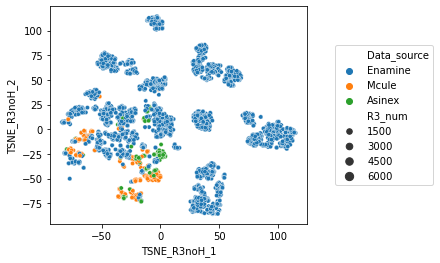

In [63]:
## Only showing the 1st appearing mol in the 'murcko_identical_id' group/cluster with more than X members
data3 = df_all[df_all['R3_num'] > 0].groupby('R3_identical_id').nth(0).reset_index()
len(data3)
## by removing [H] substituent cpds, the plot is more focused on the relevant chemical space
sns_tsne = sns.scatterplot(data=data3, x='TSNE_R3noH_1', y='TSNE_R3noH_2', size='R3_num',hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_tsne.legend(loc='center right', bbox_to_anchor=(1.51,.5))

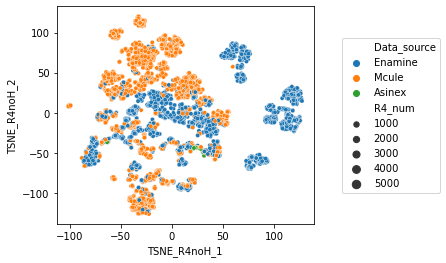

In [64]:
## Only showing the 1st appearing mol in the 'murcko_identical_id' group/cluster with more than X members
data4 = df_all[df_all['R4_num'] > 0].groupby('R4_identical_id').nth(0).reset_index()
len(data4)

sns_tsne = sns.scatterplot(data=data4, x='TSNE_R4noH_1', y='TSNE_R4noH_2', size='R4_num', hue='Data_source')
plt.subplots_adjust(right=0.72)
sns_tsne.legend(loc='center right', bbox_to_anchor=(1.51,.5))

In [67]:
df_out = df_all.fillna('').drop(columns=['Mol_murcko','Mol_hetero_murcko','Core','R1','R2','R3','R4','Fullfp','R1fp','R2fp','R3fp','R4fp','ecfp4','R1_ecfp4','R2_ecfp4','R3_ecfp4','R4_ecfp4'])
len(df_all.columns) - len(df_out.columns)

23

In [68]:
rdpd.WriteSDF(df_out, 'CRBN_lib_example.RGroup_clust.tsne.sdf.gz', properties=list(df_out.columns))